# GRAVITATIONAL LENS SDSSJ0819+5356

### PSF and aperture photometry

In [2]:
import utilfunctions as uf
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib import ticker
import numpy as np
import warnings
# import cupy as cp
# Packages used
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
from astropy.stats import mad_std
from astropy.wcs import WCS
import glob
import os
import pandas as pd
import copy
# import pyregion
import scipy as sp
from photutils.background import MedianBackground, MeanBackground, ModeEstimatorBackground, MMMBackground, SExtractorBackground, BiweightLocationBackground
from photutils.background import Background2D
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture
from astropy.nddata.utils import Cutout2D
from photutils.psf import IntegratedGaussianPRF, SourceGrouper
from photutils.background import MMMBackground, LocalBackground
from photutils.psf import IterativePSFPhotometry, GriddedPSFModel
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import QTable
import datetime
import math
from itertools import combinations
# import PythonPhot as pp

# _______________________________________________________________________
### PSF Photometry

In [5]:
folder_path = "/Users/alexm/OneDrive/Escritorio/CYGWIN_THINGS/LENTE/GL_SDSSJ0819+5356/lens_images"
files_in_folder = os.listdir(folder_path)
# files_in_folder.remove('find_psf2.ipynb')
print(files_in_folder)
# Filter out files that contain "psf" in their names
filtered_files = [file for file in files_in_folder if "psf2"  in file.lower()]
# filtered_files.remove('prova.fits')
print((filtered_files))
print(len(filtered_files))

['find_psf_and_file_txt.ipynb', 'fit.log', 'galfit.01', 'galfit.02', 'galfit.03', 'galfit.04', 'galfit.05', 'galfit.06', 'galfit.07', 'galfit.08', 'galfit.09', 'galfit.10', 'galfit.11', 'galfit.12', 'galfit.13', 'galfit.14', 'galfit.15', 'galfit.16', 'galfit.17', 'galfit.18', 'galfit.19', 'galfit.20', 'galfit.21', 'galfit.22', 'galfit.23', 'galfit.24', 'galfit.25', 'galfit.26', 'galfit.27', 'galfit.28', 'galfit.29', 'galfit.30', 'galfit.31', 'galfit.32', 'galfit.33', 'galfit.34', 'galfit.35', 'galfit.36', 'galfit.37', 'galfit.38', 'galfit.39', 'galfit.40', 'galfit.41', 'galfit.42', 'galfit.43', 'galfit.44', 'galfit.45', 'galfit.46', 'galfit.47', 'galfit.48', 'galfit.49', 'galfit.50', 'galfit.51', 'galfit.52', 'galfit.53', 'galfit.54', 'galfit.55', 'galfit.56', 'galfit.57', 'galfit0.txt', 'galfit1.txt', 'galfit10.txt', 'galfit100.txt', 'galfit101.txt', 'galfit102.txt', 'galfit103.txt', 'galfit104.txt', 'galfit105.txt', 'galfit106.txt', 'galfit107.txt', 'galfit108.txt', 'galfit109.txt', 

In [22]:
# PSF PHOTOMETRY USING DAOPHOT

warnings.filterwarnings("ignore") # Not showing warmings

# image_paths = images_paths_iKon

coords = np.array([[124.998243440, 53.940423310],[124.998243440, 53.940423310],[125.037078920, 53.968357790], [125.013046340, 53.934497430], [125.010332700, 53.927527680], [125.024931110, 53.921033100], [125.023014140, 53.950554040]]) # D, E, G, I, K
#coords = cp.asarray([[124.998243440, 53.940423310],[124.998243440, 53.940423310],[125.037078920, 53.968357790], [125.013046340, 53.934497430], [125.012248390, 53.931427250], [125.010332700, 53.927527680], [124.985519970, 53.943565380], [125.024931110, 53.921033100], [124.985143180, 53.950553540], [125.023014140, 53.950554040]]) # A, B, D, E, F, G, H, I, J, K
coordsstars = np.array([[124.998243440, 53.940423310],[124.998243440, 53.940423310],[125.037078920, 53.968357790], [125.013046340, 53.934497430], [125.010332700, 53.927527680], [125.024931110, 53.921033100], [125.023014140, 53.950554040]]) # D, E, G, I, K
coordcomp = np.array([[124.998243440, 53.940423310],[124.998243440, 53.940423310]])
# Components coordinates
coordsA=[124.998243440, 53.940423310]#A
coordsB=[125.00007152, 53.93966377] #B ra_decB = w_image.pixel_to_world( xA+3.367/0.507, yA+2.226/0.507)
coordsG=[124.999185780, 53.940057240] #G


bkg_estimator = LocalBackground(5, 10 , MMMBackground())
psf_model = IntegratedGaussianPRF()
daogroup = SourceGrouper(2.0)  # Group stars that are closer than 2 pixels
fitter = LevMarLSQFitter()

images_with_a_KeyErrorstars = np.array([])
images_other_errorstars = np.array([])
filters = np.array([])
dateobs = np.array([])
fwhms = np.array([])
flux = [np.asarray([]) for i in range(len(coordsstars))]  # A, B, D, E, G, I, K
eflux = [np.asarray([]) for i in range(len(coordsstars))]  # A, B, D, E, G, I, K
EXPTs = np.array([])
count=0
for i in filtered_files:
    try:
        with fits.open("out"+i[4:], memmap=True) as hdu:
            
            try:
                hdu1= fits.open(i[4:], memmap=True)
                image1, w_image, header, dateob, filter, fwhm, sky, EXPT1 = uf.getinfo(hdu1)
                image3= (hdu[3].data)
                daofind = DAOStarFinder(fwhm=fwhm, threshold=50) 
                photometry = IterativePSFPhotometry(
                finder=daofind,
                grouper=daogroup,
                psf_model=psf_model,
                localbkg_estimator=bkg_estimator,
                fitter=fitter,
                maxiters=1,
                fit_shape=(11, 11),
                aperture_radius=1.0)
                

                # if count==100:
                #     daofind = DAOStarFinder(fwhm=fwhm, threshold=100)
                #     print(sky)
                #     sources = daofind(image3)
                #     print("sources:",sources)
                    
                for j in range(len(coordsstars)):
                    if j==0 or j==1:
                        if j==0:
                            # x1, y1 = uf.radec_to_xy(coordsstars[j], w_image)
                            init_params = QTable()
                            init_params['x'] = [40-(1.980/0.507)+(3.367/0.507)]
                            init_params['y'] = [40-(1.348/0.507)+(2.226/0.507)]
                        if j==1:
                            # x1, y1 = uf.radec_to_xy(coordsstars[j], w_image)
                            init_params = QTable()
                            init_params['x'] = [40-(1.980/0.507)]
                            init_params['y'] = [40-(1.348/0.507)]
                        # print(init_params)
                        result_tab = photometry(image3, init_params=init_params)
                        
                        result_tab = result_tab.to_pandas()
                        # print(result_tab)
                        
                        flux[j] = np.append(flux[j], result_tab["flux_fit"][0])
                        eflux[j] = np.append(eflux[j], result_tab["flux_err"][0])
                    else:
                        x1, y1 = uf.radec_to_xy(coordsstars[j], w_image)
                        init_params = QTable()
                        init_params['x'] = [x1]
                        init_params['y'] = [y1]
                        result_tab = photometry(image1, init_params=init_params)
                        
                        result_tab = result_tab.to_pandas()
                        # print(result_tab)
                        
                        flux[j] = np.append(flux[j], result_tab["flux_fit"][0])
                        eflux[j] = np.append(eflux[j], result_tab["flux_err"][0])

                dateobs = np.append(dateobs, dateob)
                # filters = np.append(filters, filter)
                # 
                # fwhms = np.append(fwhms, fwhm)
                # EXPTs = np.append(EXPTs, EXPT1)
                
            except KeyError:
                images_with_a_KeyErrorstars = np.append(images_with_a_KeyErrorstars, i)

            except:
                images_other_errorstars = np.append(images_other_errorstars, i)
    except:
        continue

    # with fits.open(i[4:], memmap=True) as hdu:
    #     try:
            
    #         image, w_image, header, dateob, filter, fwhm, sky, EXPT1 = uf.getinfo(hdu)
    #         daofind = DAOStarFinder(fwhm=fwhm, threshold=50) 
    #         photometry = IterativePSFPhotometry(
    #         finder=daofind,
    #         grouper=daogroup,
    #         psf_model=psf_model,
    #         localbkg_estimator=bkg_estimator,
    #         fitter=fitter,
    #         maxiters=1,
    #         fit_shape=(11, 11),
    #         aperture_radius=1.0)
            

    #         if count==100:
    #             daofind = DAOStarFinder(fwhm=fwhm, threshold=100)
    #             print(sky)
    #             sources = daofind(image)
    #             print("hola")
                
    #         for j in range(len(coordsstars)):
                
    #             if j>1:
                    
    #                 x1, y1 = uf.radec_to_xy(coordsstars[j], w_image)
    #                 init_params = QTable()
    #                 init_params['x'] = [x1]
    #                 init_params['y'] = [y1]
                    
    #                 result_tab = photometry(image, init_params=init_params)

    #                 result_tab = result_tab.to_pandas()
                    
    #                 flux[j] = np.append(flux[j], result_tab["flux_fit"][0])
    #                 eflux[j] = np.append(eflux[j], result_tab["flux_err"][0])

    #         filters = np.append(filters, filter)
    #         dateobs = np.append(dateobs, dateob)
    #         fwhms = np.append(fwhms, fwhm)
    #         EXPTs = np.append(EXPTs, EXPT1)
            
    #     except KeyError:
    #         images_with_a_KeyErrorstars = np.append(images_with_a_KeyErrorstars, i)
    
    count+=1
    
print( len(images_with_a_KeyErrorstars), len(images_other_errorstars))

0 0


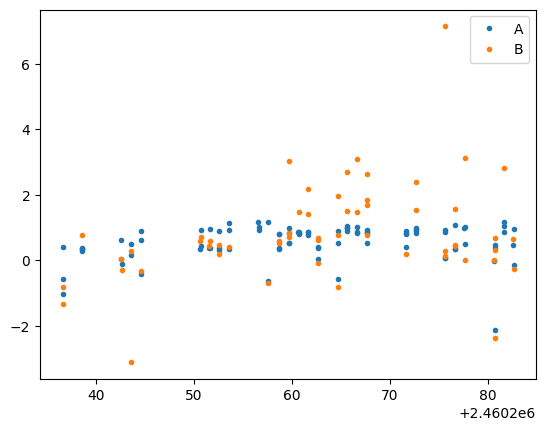

In [43]:
mage=-2.5*np.log10(flux[0]/flux[5])
mage2=-2.5*np.log10(flux[1]/flux[5])
mage3=-2.5*np.log10(flux[3]/flux[5])
mage4=-2.5*np.log10(flux[4]/flux[5])
plt.plot(dateobs,mage2, ".", label= f"A")
plt.plot(dateobs,mage, ".", label= f"B")
# plt.plot(dateobs,mage3, ".", label= f"σ = {np.std((mage3))}")
# plt.plot(dateobs,mage4, ".", label= f"σ = {np.std((mage4))}")
plt.legend()